In [4]:
%matplotlib inline

import pickle
import pandas as pd
from pandas import Series
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from collections import defaultdict 
from itertools import combinations


import torch
from sentence_transformers import models, SentenceTransformer
from sentence_transformers import InputExample
from sentence_transformers import losses
from torch.utils.data import DataLoader
from sentence_transformers.evaluation import TripletEvaluator

## Generation of belief triplets

### Read dataset 

In [4]:
df = pd.read_pickle('../dataset/01_Final_dataframe/df_ddo_including_only_truebeliefs_nodup(N192307).p')

In [6]:
df.head()

,debate_key,debate_title,username,debate_date,position,is_belief,belief_statement
1,.-Audis-are-junkers-except-to-rich-kids-with-l...,". Audis are junkers, except to rich kids with ...",Max.Wallace,2014-09-04,Pro,1.0,I agree with the following: . Audis are junker...
2,....-Former-Secretary-of-State-Madeleine-Albri...,"....""Former Secretary of State Madeleine Albri...",Lookingatissues,2017-01-30,Pro,1.0,"I agree with the following: ....""Former Secret..."
3,...Words-can-t-hurt-me-any./1/,...Words can't hurt me any.,NonInDelicto,2007-12-19,Pro,1.0,I agree with the following: ...Words can't hur...
4,.9-repeated-is-equal-to-1./1/,.9 repeated is equal to 1.,cowpie1998,2011-04-07,Pro,1.0,I agree with the following: .9 repeated is equ...
5,.99-is-equal-to-one./1/,.99 is equal to one.,SweetCrackerJack,2013-12-24,Pro,1.0,I agree with the following: .99 is equal to one.


In [5]:
print('data size:', len(df))
print('num debates:', len(df['debate_key'].unique()))
print('num debate title:', len(df['debate_title'].unique()))
print('num users:', len(df['username'].unique()))
print('average participation:', len(df)/len(df['username'].unique())  )
print('Unique beliefs', len(df['belief_statement'].unique()))

data size: 192307
num debates: 65861
num debate title: 59986
num users: 40280
average participation: 4.7742552135054614
Unique beliefs 119972


### Generate 5-fold dataset

In [8]:
debate_titles = df.debate_title.unique()
print(f"There are {len(debate_titles)} unique debates in debate.org dataset")

There are 59986 unique debates in debate.org dataset


In [9]:
kf = KFold(n_splits=5)
kf.get_n_splits(debate_titles)

5

In [10]:
train_indices = []
test_indices  = []

for i, (train_index, test_index) in enumerate(kf.split(debate_titles)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")  
    print(f"  Test:  index={test_index}")    
    print(len(train_index), len(test_index))

    train_indices.append(train_index)
    test_indices.append(test_index)

Fold 0:
  Train: index=[11998 11999 12000 ... 59983 59984 59985]
  Test:  index=[    0     1     2 ... 11995 11996 11997]
47988 11998
Fold 1:
  Train: index=[    0     1     2 ... 59983 59984 59985]
  Test:  index=[11998 11999 12000 ... 23992 23993 23994]
47989 11997
Fold 2:
  Train: index=[    0     1     2 ... 59983 59984 59985]
  Test:  index=[23995 23996 23997 ... 35989 35990 35991]
47989 11997
Fold 3:
  Train: index=[    0     1     2 ... 59983 59984 59985]
  Test:  index=[35992 35993 35994 ... 47986 47987 47988]
47989 11997
Fold 4:
  Train: index=[    0     1     2 ... 47986 47987 47988]
  Test:  index=[47989 47990 47991 ... 59983 59984 59985]
47989 11997


In [ ]:
for i in range(5):
    
    train_titles = debate_titles[train_indices[i]]
    test_titles = debate_titles[test_indices[i]]
    df_train = df[df['debate_title'].isin(train_titles)]
    df_test  = df[df['debate_title'].isin(test_titles)]
        
    df_train.to_pickle('../dataset/04_K-fold_dataset/df_train_idx%d.p'%(i))
    df_test.to_pickle('../dataset/04_K-fold_dataset/df_test_idx%d.p'%(i))
    
    #print("Train size:",len(df_train), "Test size:",len(df_test))

### Generate triplets

In [12]:
pro_phrase = 'I agree with the following: '
con_phrase = 'I disagree with the following: '

def get_reverse_phrase(phrase):
    if phrase == pro_phrase:
        return con_phrase
    elif phrase == con_phrase:
        return pro_phrase
    else: 
        print('error')
        
def get_opposite_belief(belief_statement):
    position = " ".join(belief_statement.split()[:5]) + ' '
    title = " ".join(belief_statement.split()[5:]) 
    
    position_r = get_reverse_phrase(position)
    opposite_belief = position_r + title
    return opposite_belief        

In [13]:
#example 
get_opposite_belief('I agree with the following: apples are delicious.')

'I disagree with the following: apples are delicious.'

In [14]:
#get a belief co-occurrence dictionary
def get_belief_cooccurrence_dic(df):
    
    df_g = df.groupby('username')
    corpus = []

    for g, data in df_g:

        data = data.sort_values(by='debate_date')
        user_beliefs = list(data['belief_statement'].unique())
        corpus.append(user_beliefs)
        
    
    belief2list = defaultdict(list)
    
    for b_list in corpus:
        if len(b_list) == 1: 
            continue

        for e1 in b_list:
            for e2 in b_list:
                if e1 != e2:
                    belief2list[e1].append(e2)
                    
    return belief2list

In [15]:
dic_co = get_belief_cooccurrence_dic(df)

In [16]:
len(dic_co)

102881

In [17]:
#Get triplets using the belief co-occurrence dictionary
def get_stance_triplet(belief2list):
    
    belief_triplet = []

    for s in tqdm(belief2list):

        anchor = s
        positive_samples = belief2list[s] 
        opposite_belief = get_opposite_belief(s)

        if not opposite_belief in belief2list: #use only direct opposite stance as a negative sample
            negative_samples = [opposite_belief]
        else:
            negative_samples = [opposite_belief] + belief2list[opposite_belief]

        #if vote history is too long: Sample 5 stances from history 
        thres = 5
        if len(positive_samples) > thres-1:
            positive_samples = np.random.choice(positive_samples, size=thres, replace=False)

        if len(negative_samples) > thres-1:
            #to ensure including directly opposite stance
            other_samples = np.random.choice(negative_samples[1:], size=thres-1, replace=False)        
            negative_samples = np.concatenate((negative_samples[:1], other_samples)) 

        #make triplet examples 
        for pos in positive_samples:
            for neg in negative_samples:
                example = [anchor, pos, neg]
                belief_triplet.append(example)
    
    return belief_triplet

In [ ]:
for i in tqdm(range(5)):
    df_train = pd.read_pickle('../dataset/04_K-fold_dataset/df_train_idx%d.p'%(i))
    df_test = pd.read_pickle('../dataset/04_K-fold_dataset/df_test_idx%d.p'%(i))

    belief2list_train = get_belief_cooccurrence_dic(df_train)
    belief2list_test  = get_belief_cooccurrence_dic(df_test)
    
    train_triplets = get_stance_triplet(belief2list_train)
    test_triplets  = get_stance_triplet(belief2list_test)
    
    with open('../dataset/04_K-fold_triplets/train_triplet_idx%d.p'%i,'wb') as f:
        pickle.dump(train_triplets, f)
        
    with open('../dataset/04_K-fold_triplets/test_triplet_idx%d.p'%i,'wb') as f:
        pickle.dump(test_triplets, f)

## Train / Test set with commonly appearing users

In [21]:
train_sets = []
test_sets  = []

BASE_PATH = '../dataset/04_K-fold_dataset/'

for i in range(5):    
    
    df_train = pd.read_pickle(BASE_PATH + 'df_train_idx%d.p'%(i))
    df_test  = pd.read_pickle(BASE_PATH + 'df_test_idx%d.p'%(i))
        
    train_users = df_train.username.unique()
    test_users  = df_test.username.unique()
    
    common_users = []
    for u in test_users:
        if u in train_users:
            common_users.append(u)
    
    df_train_common = df_train[df_train['username'].isin(common_users)]
    df_test_common  = df_test[df_test['username'].isin(common_users)]
    
    
    train_sets.append(df_train_common)
    test_sets.append(df_test_common)
    
    print("Dataset idx:%d"%(i))
    print("# votes: Train, Train_common, Test, Test_common")
    print(len(df_train), len(df_train_common), len(df_test), len(df_test_common))
    print("# voters: Train, Train_common, Test, Test_common")
    print(len(df_train.username.unique()), len(df_train_common.username.unique()), len(df_test.username.unique()), len(df_test_common.username.unique()))
    print()

Dataset idx:0
# votes: Train, Train_common, Test, Test_common
153698 111724 38609 33208
# voters: Train, Train_common, Test, Test_common
35447 10173 15006 10173

Dataset idx:1
# votes: Train, Train_common, Test, Test_common
151618 110860 40689 35171
# voters: Train, Train_common, Test, Test_common
35362 10401 15319 10401

Dataset idx:2
# votes: Train, Train_common, Test, Test_common
151524 107163 40783 36060
# voters: Train, Train_common, Test, Test_common
36092 9706 13894 9706

Dataset idx:3
# votes: Train, Train_common, Test, Test_common
157602 113625 34705 27733
# voters: Train, Train_common, Test, Test_common
34205 9675 15750 9675

Dataset idx:4
# votes: Train, Train_common, Test, Test_common
154786 110227 37521 33007
# voters: Train, Train_common, Test, Test_common
36220 9744 13804 9744



In [ ]:
BASE_PATH = '../dataset/04_K-fold_dataset_commonusers/'

for i in range(5):    
    
    train_sets[i].to_pickle(BASE_PATH + 'df_commonuser_train_idx%d.p'%(i))
    test_sets[i].to_pickle(BASE_PATH + 'df_commonuser_test_idx%d.p'%(i))

## Fine-tuing Sentence-BERT model

### Training S-BERT

In [ ]:
for data_index in range(5): #iteration over K-fold 

    #Load dataset 
    filepath = '../dataset/04_K-fold_triplets/train_triplet_idx%d.p'%(data_index) 

    with open(filepath,'rb') as f:
        triplet_data = pickle.load(f)

    #Make InputExamples to use it as input for Data loader 
    triplets = []
    for e in tqdm(triplet_data):
        triplets.append(InputExample(texts = e))

    #Data Loader 
    batch_size = 32
    loader = DataLoader(triplets, shuffle=True, batch_size=batch_size)    
   
    num_epochs = 5
    for epoch in range(num_epochs):
        
        print("Dataidx: %d, epoch: %d"%(data_index, epoch))
        
        if epoch == 0:
            model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')        
        else:
            model = SentenceTransformer('../model/roberta-base_idx%d_epoch%d'%(data_index, epoch))
            
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
        model.to(device)

        loss = losses.TripletLoss(model)
        savepath = '../model/roberta-base_idx%d_epoch%d'%(data_index, epoch+1)
        
        model.fit(
            train_objectives=[(loader, loss)],
            epochs=1,
            output_path=savepath,
            show_progress_bar=True
        )


### Training original-BERT

In [ ]:
for data_index in range(5): 

    #Load dataset 
    filepath = '../dataset/04_K-fold_triplets/train_triplet_idx%d.p'%(data_index) 

    with open(filepath,'rb') as f:
        triplet_data = pickle.load(f)

    print(f"Total # tripliets : {len(triplet_data)}")

    
    #Make InputExamples to use it as input for Data loader 
    triplets = []
    for e in tqdm(triplet_data):
        triplets.append(InputExample(texts = e))

    #Data Loader 
    batch_size = 32
    loader = DataLoader(triplets, shuffle=True, batch_size=batch_size)    


    #Model preparation - BERT 
    bert = models.Transformer('bert-base-uncased')

    pooler = models.Pooling(
                bert.get_word_embedding_dimension(), #768
                    pooling_mode_mean_tokens=True #mean pooling
                    )
    model = SentenceTransformer(modules=[bert, pooler])

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model.to(device)
    print("device: ", model.device)


    #Train model 
    loss = losses.TripletLoss(model)
    epochs = 5
    
    for epoch in range(epochs):
        
        savepath = '../model/finetuned-BERT_idx%d_epoch%d'%(data_index, epoch+1)
        
        model.fit(
            train_objectives=[(loader, loss)],
            epochs=1,
            output_path=savepath,
            show_progress_bar=True
        )

## Triplet Evaluation 

### BASE S-BERT without fine-tuning 

In [ ]:
for foldidx in range(5):

    #Train set
    filepath = '../dataset/04_K-fold_triplets/train_triplet_idx%d.p'%(foldidx)

    with open(filepath,'rb') as f:
        triplet_data = pickle.load(f)

    triplet_data = pd.Series(triplet_data)
    triplet_data = triplet_data.sample(100000, random_state=99).to_list()
    
    train_samples = []
    for e in tqdm(triplet_data):
        train_samples.append(InputExample(texts = e))

    model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')    

    #Evaluator, using train samples
    triplet_evaluator = TripletEvaluator.from_input_examples(
        train_samples,
        write_csv=True,
        show_progress_bar=True,
        name = 'roberta-base_untrained_(trainset)idx%d'%(foldidx)
    )

    output_path = '../eval/'
    triplet_evaluator(model, output_path=output_path)

    #Test set
    filepath = '../dataset/04_K-fold_triplets/test_triplet_idx%d.p'%(foldidx)

    with open(filepath,'rb') as f:
        triplet_data = pickle.load(f)

    triplet_data = pd.Series(triplet_data)
    triplet_data = triplet_data.sample(100000, random_state=99).to_list()
    
    test_samples = []
    for e in tqdm(triplet_data):
        test_samples.append(InputExample(texts = e))

    model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')    

    #Evaluator, using train samples
    triplet_evaluator = TripletEvaluator.from_input_examples(
        test_samples,
        write_csv=True,
        show_progress_bar=True,
        name = 'roberta-base_untrained_(testset)idx%d'%(foldidx)
    )

    output_path = '../eval/'
    triplet_evaluator(model, output_path=output_path)

### Base BERT (without finetuing)

In [ ]:
#BASE BERT 
for foldidx in range(5):

    print(foldidx)
    
    #Train set
    filepath = '../dataset/04_K-fold_triplets/train_triplet_idx%d.p'%(foldidx)

    with open(filepath,'rb') as f:
        triplet_data = pickle.load(f)

    triplet_data = pd.Series(triplet_data)
    triplet_data = triplet_data.sample(100000, random_state=99).to_list()
    
    train_samples = []
    for e in tqdm(triplet_data):
        train_samples.append(InputExample(texts = e))

    bert = models.Transformer('bert-base-uncased')

    pooler = models.Pooling(
        bert.get_word_embedding_dimension(), #768
        pooling_mode_mean_tokens=True #mean pooling
    )
    model = SentenceTransformer(modules=[bert, pooler])

    #Evaluator, using train samples
    triplet_evaluator = TripletEvaluator.from_input_examples(
        train_samples,
        write_csv=True,
        show_progress_bar=True,
        name = 'bert_untrained_(trainset)_idx%d'%(foldidx)
    )

    output_path = '../eval/'
    triplet_evaluator(model, output_path=output_path)


    #Test set
    print(foldidx)
    filepath = '../dataset/04_K-fold_triplets/test_triplet_idx%d.p'%(foldidx)

    with open(filepath,'rb') as f:
        triplet_data = pickle.load(f)

    triplet_data = pd.Series(triplet_data)
    triplet_data = triplet_data.sample(100000, random_state=99).to_list()
    
    test_samples = []
    for e in tqdm(triplet_data):
        test_samples.append(InputExample(texts = e))

    bert = models.Transformer('bert-base-uncased')

    pooler = models.Pooling(
        bert.get_word_embedding_dimension(), #768
        pooling_mode_mean_tokens=True #mean pooling
    )
    model = SentenceTransformer(modules=[bert, pooler])

    #Evaluator, using train samples
    triplet_evaluator = TripletEvaluator.from_input_examples(
        test_samples,
        write_csv=True,
        show_progress_bar=True,
        name = 'bert_untrained_(testset)_idx%d'%(foldidx)
    )

    output_path = '../eval/'
    triplet_evaluator(model, output_path=output_path)
    


### Finetuned S-BERT triplet evaluation

In [ ]:
data_index_list = [0,1,2,3,4]
epochs = [1,2,3,4,5]

for data_index in data_index_list:
    for epoch in epochs:

        print("data idx:", data_index, 'epoch', epoch)

        #TRAIN DATSET
        filepath = '../dataset/04_K-fold_triplets/train_triplet_idx%d.p'%(data_index) 

        with open(filepath,'rb') as f:
            triplet_data = pickle.load(f)

        triplet_data = pd.Series(triplet_data)
        triplet_data = triplet_data.sample(100000, random_state=99).to_list()
        
        train_samples = []
        for e in tqdm(triplet_data):
            train_samples.append(InputExample(texts = e))

        #Test DATSET
        filepath = '../dataset/04_K-fold_triplets/test_triplet_idx%d.p'%(data_index) 

        with open(filepath,'rb') as f:
            triplet_data = pickle.load(f)

        triplet_data = pd.Series(triplet_data)
        triplet_data = triplet_data.sample(100000, random_state=99).to_list()
        
        test_samples = []
        for e in tqdm(triplet_data):
            test_samples.append(InputExample(texts = e))

            
        #Load model 
        modelpath = '../model/roberta-base_idx%d_epoch%d'%(data_index, epoch)
        model = SentenceTransformer(modelpath)    

        #Evaluate using train samples
        triplet_evaluator = TripletEvaluator.from_input_examples(
            train_samples,
            write_csv=True,
            show_progress_bar=True,
            name = 'roberta-base-Train_idx%d_epoch%d'%(data_index, epoch)
        )
        output_path = '../eval/'
        triplet_evaluator(model, output_path=output_path)

        #Evaluate using test samples
        triplet_evaluator = TripletEvaluator.from_input_examples(
            test_samples,
            write_csv=True,
            show_progress_bar=True,
            name = 'roberta-base-Test_idx%d_epoch%d'%(data_index, epoch)
        )
        output_path = '../eval/'
        triplet_evaluator(model, output_path=output_path)




### Finetuned BERT triplet evaluation

In [ ]:
data_index_list = [0,1,2,3,4]
epochs = [1,2,3,4,5]

for data_index in data_index_list:
    for epoch in epochs:

        print("data idx:", data_index, 'epoch', epoch)

        #TRAIN DATSET
        filepath = '../dataset/04_K-fold_triplets/train_triplet_idx%d.p'%(data_index) 

        with open(filepath,'rb') as f:
            triplet_data = pickle.load(f)

        triplet_data = pd.Series(triplet_data)
        triplet_data = triplet_data.sample(100000, random_state=99).to_list()
        
        train_samples = []
        for e in tqdm(triplet_data):
            train_samples.append(InputExample(texts = e))

        #Test DATSET
        filepath = '../dataset/04_K-fold_triplets/test_triplet_idx%d.p'%(data_index) 

        with open(filepath,'rb') as f:
            triplet_data = pickle.load(f)

        triplet_data = pd.Series(triplet_data)
        triplet_data = triplet_data.sample(100000, random_state=99).to_list()
        
        test_samples = []
        for e in tqdm(triplet_data):
            test_samples.append(InputExample(texts = e))

            
        #Load finetuned-BERT model 
        modelpath = '../model/finetuned-BERT_idx%d_epoch%d'%(data_index, epoch)
        model = SentenceTransformer(modelpath)    

        #Evaluate using train samples
        triplet_evaluator = TripletEvaluator.from_input_examples(
            train_samples,
            write_csv=True,
            show_progress_bar=True,
            name = 'finetuned-BERT-Train_idx%d_epoch%d'%(data_index, epoch)
        )
        output_path = '../eval/'
        triplet_evaluator(model, output_path=output_path)

        #Evaluate using test samples
        triplet_evaluator = TripletEvaluator.from_input_examples(
            test_samples,
            write_csv=True,
            show_progress_bar=True,
            name = 'finetuned-BERT-Test_idx%d_epoch%d'%(data_index, epoch)
        )
        output_path = '../eval/'
        triplet_evaluator(model, output_path=output_path)

## Evaluation result 

### BERT-finetuned

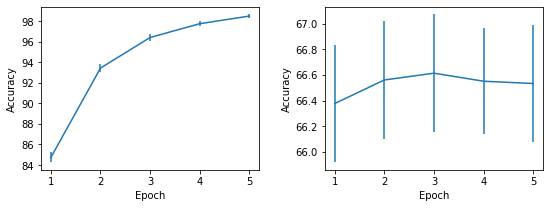

In [23]:
model_type = 'finetuned-BERT'
data_type_list = ['Train', 'Test']
data_index_list = [0,1,2,3,4]

figs, axes = plt.subplots(1,2, figsize=(9,3))

acc_cos_over_epochs = {}
std_cos_over_epochs = {}
acc_euc_over_epochs = {}
std_euc_over_epochs = {}

for tid, data_type in enumerate(data_type_list):    

    acc_cos_over_epochs[data_type] = []
    std_cos_over_epochs[data_type] = []
    acc_euc_over_epochs[data_type] = []
    std_euc_over_epochs[data_type] = []
    
    for epoch in range(1,6):
        
        acc_cosine = []
        acc_euclid = []

        for data_index in data_index_list:
            filepath = '../eval/triplet_evaluation_%s-%s_idx%d_epoch%d_results.csv'%(model_type, data_type, data_index, epoch)
            df = pd.read_csv(filepath)
            
            acc_cosine.append(df['accuracy_cosinus'][0])
            acc_euclid.append(df['accuracy_euclidean'][0])    

        acc_cos_over_epochs[data_type].append(np.mean(acc_cosine)*100)
        acc_euc_over_epochs[data_type].append(np.mean(acc_euclid)*100)
        std_cos_over_epochs[data_type].append(np.std(acc_cosine)*100)
        std_euc_over_epochs[data_type].append(np.std(acc_euclid)*100)

        #print("Model : %5s, %5s, Acc_cosine : %.2f%%, Acc_eulidean : %.2f%%"%(model_type, data_type, np.mean(acc_cosine)*100, np.mean(acc_euclid)*100))
        #print("Model : %5s, %5s, std_cosine : %.3f, std_eulidean : %.3f"%(model_type, data_type, np.std(acc_cosine)*100, np.std(acc_euclid)*100))

    axes[tid].errorbar(x=np.arange(1,6), y=acc_euc_over_epochs[data_type], yerr=std_euc_over_epochs[data_type])
    axes[tid].set_xlabel('Epoch')
    axes[tid].set_ylabel('Accuracy')

plt.subplots_adjust(wspace=0.3)
#plt.savefig('../fig/Triplet_loss_(BERT).pdf', transparent=True, bbox_inches='tight')
    

### S-BERT( roberta-base-nli-stsb-mean-tokens) finetuned

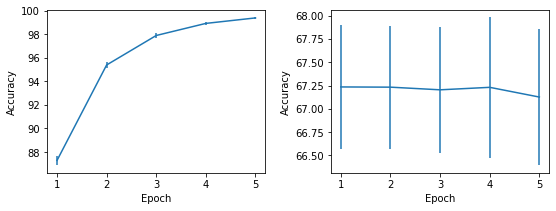

In [25]:
data_type_list = ['Train', 'Test']
data_index_list = [0,1,2,3,4]

figs, axes = plt.subplots(1,2, figsize=(9,3))

acc_cos_over_epochs_sb = {}
std_cos_over_epochs_sb = {}
acc_euc_over_epochs_sb = {}
std_euc_over_epochs_sb = {}

for tid, data_type in enumerate(data_type_list):

    acc_cos_over_epochs_sb[data_type] = []
    std_cos_over_epochs_sb[data_type] = []
    acc_euc_over_epochs_sb[data_type] = []
    std_euc_over_epochs_sb[data_type] = []
    
    for epoch in range(1,6):
        
        acc_cosine = []
        acc_euclid = []

        for data_index in data_index_list:
            filepath = '../eval/triplet_evaluation_roberta-base-%s_idx%d_epoch%d_results.csv'%(data_type, data_index, epoch)
            df = pd.read_csv(filepath)
            
            acc_cosine.append(df['accuracy_cosinus'][0])
            acc_euclid.append(df['accuracy_euclidean'][0])    

        acc_cos_over_epochs_sb[data_type].append(np.mean(acc_cosine)*100)
        acc_euc_over_epochs_sb[data_type].append(np.mean(acc_euclid)*100)
        std_cos_over_epochs_sb[data_type].append(np.std(acc_cosine)*100)
        std_euc_over_epochs_sb[data_type].append(np.std(acc_euclid)*100)

        #print("Model : %5s, %5s, Acc_cosine : %.2f%%, Acc_eulidean : %.2f%%"%(model_type, data_type, np.mean(acc_cosine)*100, np.mean(acc_euclid)*100))
        #print("Model : %5s, %5s, std_cosine : %.3f, std_eulidean : %.3f"%(model_type, data_type, np.std(acc_cosine)*100, np.std(acc_euclid)*100))

    axes[tid].errorbar(x=np.arange(1,6), y=acc_euc_over_epochs_sb[data_type], yerr=std_euc_over_epochs_sb[data_type])
    axes[tid].set_xlabel('Epoch')
    axes[tid].set_ylabel('Accuracy')

plt.subplots_adjust(wspace=0.3)
#plt.savefig('../fig/Triplet_loss_(S-BERT).pdf', transparent=True, bbox_inches='tight')


### Base model (BERT, S-BERT)

In [26]:
model_type = 'base BERT'
data_type_list = ['trainset', 'testset']
data_index_list = [0,1,2,3,4]

acc_cos_over_epochs_base_bert = {}
std_cos_over_epochs_base_bert = {}
acc_euc_over_epochs_base_bert = {}
std_euc_over_epochs_base_bert = {}

for tid, data_type in enumerate(data_type_list):    

    acc_cos_over_epochs_base_bert[data_type] = []
    std_cos_over_epochs_base_bert[data_type] = []
    acc_euc_over_epochs_base_bert[data_type] = []
    std_euc_over_epochs_base_bert[data_type] = []
    
    acc_cosine = []
    acc_euclid = []

    for data_index in data_index_list:
        filepath = '../eval/triplet_evaluation_bert_untrained_(%s)_idx%d_results.csv'%(data_type, data_index)
        df = pd.read_csv(filepath)
        
        acc_cosine.append(df['accuracy_cosinus'][0])
        acc_euclid.append(df['accuracy_euclidean'][0])    

    acc_cos_over_epochs_base_bert[data_type].append(np.mean(acc_cosine)*100)
    acc_euc_over_epochs_base_bert[data_type].append(np.mean(acc_euclid)*100)
    std_cos_over_epochs_base_bert[data_type].append(np.std(acc_cosine)*100)
    std_euc_over_epochs_base_bert[data_type].append(np.std(acc_euclid)*100)

        #print("Model : %5s, %5s, Acc_cosine : %.2f%%, Acc_eulidean : %.2f%%"%(model_type, data_type, np.mean(acc_cosine)*100, np.mean(acc_euclid)*100))
        #print("Model : %5s, %5s, std_cosine : %.3f, std_eulidean : %.3f"%(model_type, data_type, np.std(acc_cosine)*100, np.std(acc_euclid)*100))

print(acc_cos_over_epochs_base_bert)

{'trainset': [37.7008], 'testset': [35.907799999999995]}


In [27]:
print("%.3f"%acc_euc_over_epochs_base_bert['trainset'][0])
print("%.3f"%std_euc_over_epochs_base_bert['trainset'][0])
print("%.3f"%acc_euc_over_epochs_base_bert['testset'][0])
print("%.3f"%std_euc_over_epochs_base_bert['testset'][0])

37.669
0.212
35.890
0.774


In [28]:
#S-BERT
model_type = 'roberta-base'
data_type_list = ['trainset', 'testset']
data_index_list = [0,1,2,3,4]

acc_cos_over_epochs_base_sbert = {}
std_cos_over_epochs_base_sbert = {}
acc_euc_over_epochs_base_sbert = {}
std_euc_over_epochs_base_sbert = {}

for tid, data_type in enumerate(data_type_list):    

    acc_cos_over_epochs_base_sbert[data_type] = []
    std_cos_over_epochs_base_sbert[data_type] = []
    acc_euc_over_epochs_base_sbert[data_type] = []
    std_euc_over_epochs_base_sbert[data_type] = []
    
    acc_cosine = []
    acc_euclid = []

    for data_index in data_index_list:
        filepath = '../eval/triplet_evaluation_roberta-base_untrained_(%s)idx%d_results.csv'%(data_type, data_index)
        df = pd.read_csv(filepath)
        
        acc_cosine.append(df['accuracy_cosinus'][0])
        acc_euclid.append(df['accuracy_euclidean'][0])    

    acc_cos_over_epochs_base_sbert[data_type].append(np.mean(acc_cosine)*100)
    acc_euc_over_epochs_base_sbert[data_type].append(np.mean(acc_euclid)*100)
    std_cos_over_epochs_base_sbert[data_type].append(np.std(acc_cosine)*100)
    std_euc_over_epochs_base_sbert[data_type].append(np.std(acc_euclid)*100)

        #print("Model : %5s, %5s, Acc_cosine : %.2f%%, Acc_eulidean : %.2f%%"%(model_type, data_type, np.mean(acc_cosine)*100, np.mean(acc_euclid)*100))
        #print("Model : %5s, %5s, std_cosine : %.3f, std_eulidean : %.3f"%(model_type, data_type, np.std(acc_cosine)*100, np.std(acc_euclid)*100))

print(acc_cos_over_epochs_base_sbert)

{'trainset': [39.83519999999999], 'testset': [38.1918]}


In [29]:
print("%.3f"%acc_euc_over_epochs_base_sbert['trainset'][0])
print("%.3f"%std_euc_over_epochs_base_sbert['trainset'][0])
print("%.3f"%acc_euc_over_epochs_base_sbert['testset'][0])
print("%.3f"%std_euc_over_epochs_base_sbert['testset'][0])

39.832
0.194
38.111
1.010


### Aggregated result 

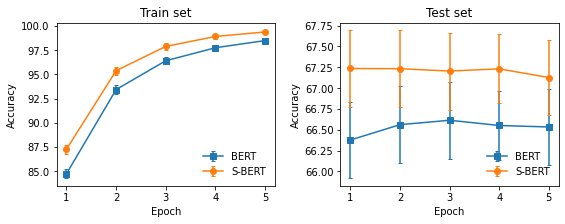

In [31]:
figs, axes = plt.subplots(1,2, figsize=(9,3))

ax1 = axes[0]
ax1.errorbar(np.arange(1,6), acc_euc_over_epochs['Train'], std_euc_over_epochs['Train'], fmt='s-', capsize=2, label='BERT')
ax1.errorbar(np.arange(1,6), acc_euc_over_epochs_sb['Train'], std_euc_over_epochs['Train'], fmt='o-', capsize=2, label='S-BERT')
#ax1.axhline(acc_euc_over_epochs_base_bert['trainset'][0], ls='--')
#ax1.axhline(acc_euc_over_epochs_base_sbert['trainset'][0], ls='--', color='orange')
ax1.legend(frameon=False, loc=4)
ax1.set_title('Train set')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')


ax2 = axes[1]
ax2.errorbar(np.arange(1,6), acc_euc_over_epochs['Test'], std_euc_over_epochs['Test'], fmt='s-', capsize=2, label='BERT')
ax2.errorbar(np.arange(1,6), acc_euc_over_epochs_sb['Test'], std_euc_over_epochs['Test'], fmt='o-', capsize=2, label='S-BERT')
#ax2.axhline(acc_euc_over_epochs_base_bert['testset'][0], ls='--')
#ax2.axhline(acc_euc_over_epochs_base_sbert['testset'][0], ls='--', color='orange')
#ax2.set_ylim(65,68)
ax2.set_title('Test set')
ax2.legend(frameon=False, loc=4)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

plt.subplots_adjust(wspace=0.3)
#plt.savefig('../fig/Triplet_loss_(BERT_vs_S-BERT).pdf', transparent=True, bbox_inches='tight')

## Sentence textual similarity (STS) evaluation 

In [1]:
import datasets
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

In [2]:
sts = datasets.load_dataset('glue', 'stsb', split='validation')

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [7]:
sts = datasets.load_dataset('glue', 'stsb', split='validation')
sts = sts.map(lambda x: {'label': x['label'] / 5.0})

samples = []
for sample in sts:
    samples.append(InputExample(
      texts = [sample['sentence1'], sample['sentence2']],
      label = sample['label']
    ))
    
embedding_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    samples, write_csv=False
)

### BERT, S-BERT, (base models, and fine-tuned models) evaluation

In [8]:
bert = models.Transformer('bert-base-uncased')

pooler = models.Pooling(
    bert.get_word_embedding_dimension(), #768
    pooling_mode_mean_tokens=True #mean pooling
)
model1 = SentenceTransformer(modules=[bert, pooler])

embedding_evaluator(model1)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

0.6146284960227489

In [9]:
base_sbert = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')    
embedding_evaluator(base_sbert)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/334 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

0.8770375704453881

In [ ]:
data_index_list = [0,1,2,3,4]
sts_over_epochs_bert = []
sts_over_epochs_std_bert = []

for epoch in range(1,6,1):

    sts_result = []

    for data_index in data_index_list:
        
        #Load model 
        modelpath = '../model/finetuned-BERT_idx%d_epoch%d'%(data_index, epoch)
        model = SentenceTransformer(modelpath)    
        
        score = embedding_evaluator(model)
        #print(score)
        sts_result.append(score)

    sts_over_epochs_bert.append(np.mean(sts_result))
    sts_over_epochs_std_bert.append(np.std(sts_result))
    
print("%.3f, (%.3f)"%(np.mean(sts_over_epochs_bert), np.std(sts_result)))    

In [ ]:
data_index_list = [0,1,2,3,4]
sts_over_epochs = []
sts_over_epochs_std = []

for epoch in range(1,6,1):

    sts_result = []
    
    for data_index in data_index_list:
        
        #Load model 
        modelpath = '../model/roberta-base_idx%d_epoch%d'%(data_index, epoch)
        model = SentenceTransformer(modelpath)    
            
        score = embedding_evaluator(model)
        #print(score)
        sts_result.append(score)

    sts_over_epochs.append(np.mean(sts_result))
    sts_over_epochs_std.append(np.std(sts_result))

In [ ]:
plt.figure(figsize=(4,3))
plt.errorbar(np.arange(1,6,1), sts_over_epochs_bert, yerr=sts_over_epochs_std_bert, fmt='o-', capsize=2, label='Fine-tuned BERT')
plt.errorbar(np.arange(1,6,1), sts_over_epochs, yerr=sts_over_epochs_std, fmt='s-', capsize=2, label='Fine-tuned S-BERT')
plt.title('GLUE-STSB')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Spearman correlation score')
plt.xticks(np.arange(1,6,1))
#plt.savefig('../fig/GLUE-STSB evaluation.pdf', transparent=True, bbox_inches='tight')
plt.show()

## Generation of belief embeddings

In [ ]:
#We use fine-tuned models (for 3 epochs) 

for data_idx in [0,1,2,3,4]:

    #1.Load data
    df_train = pd.read_pickle('../dataset/04_K-fold_dataset/df_train_idx%d.p'%(data_idx))
    df_test  = pd.read_pickle('../dataset/04_K-fold_dataset/df_test_idx%d.p'%(data_idx))

    
    len(df_train), len(df_test)

    train_titles = df_train.debate_title.unique()
    test_titles = df_test.debate_title.unique()

    print("data %d"%(data_idx))
    print(f"There are {len(train_titles)} debate titles in train datasets")
    print(f"There are {len(test_titles)} debate titles in test datasets")

    train_stances = df_train.belief_statement.unique()
    test_stances = df_test.belief_statement.unique()

    print(f"There are {len(train_stances)} debate stances in train datasets")
    print(f"There are {len(test_stances)} debate stances in test datasets")


    #2.Load model

    #BERT Model
    bert = models.Transformer('bert-base-uncased')
    pooler = models.Pooling(
        bert.get_word_embedding_dimension(), #768
        pooling_mode_mean_tokens=True #mean pooling
    )
    model_bert = SentenceTransformer(modules=[bert, pooler])


    #Fine-tuned BERT model
    MODEL_PATH = '../model/finetuned-BERT_idx%d_epoch3'%(data_idx)
    model_bert_ft = SentenceTransformer(MODEL_PATH)

    #roberta-base
    model_roberta_base = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')       

    #finetuned roberta-base
    MODEL_PATH = '../model/roberta-base_idx%d_epoch3'%(data_idx)
    model_roberta_base_ft = SentenceTransformer(MODEL_PATH)

    #3. Get embedding vector    
    model_list = [model_bert, model_bert_ft, model_roberta_base, model_roberta_base_ft]
    model_labels = ['model_bert','model_bert_ft', 'model_roberta-base', 'model_roberta-base_ft']

    for m_idx, model in enumerate(model_list):
        print(model_labels[m_idx])

        train_embeddings = [] 
        for e in tqdm(train_stances):
            train_embeddings.append(model.encode(e))

        train_stance2embeddings = {}
        for i in range(len(train_stances)):
            train_stance2embeddings[train_stances[i]] = train_embeddings[i]

        with open('../dataset/BeliefEmbeddingResults/BeliefEmbeddings_data(%d)_model(%s).p'%(data_idx, model_labels[m_idx]), 'wb') as f:
            pickle.dump(train_stance2embeddings, f)


## Belief prediction downstream task

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import binned_statistic
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [14]:
data_indices = [0,1,2,3,4]
model_types = ['model_bert_ft', 'model_roberta-base_ft', 'model_bert', 'model_roberta-base']
model_labels = ['Finetuned BERT', 'Finetuned SBERT', 'BERT', 'SBERT'] 

In [15]:
def load_model(model_type, data_idx):
    
    if model_type == 'model_bert':
        bert = models.Transformer('bert-base-uncased')
        pooler = models.Pooling(
            bert.get_word_embedding_dimension(), #768
            pooling_mode_mean_tokens=True #mean pooling
        )
        model = SentenceTransformer(modules=[bert, pooler])    
    
    if model_type == 'model_bert_ft':
        MODEL_PATH = '../model/finetuned-BERT_idx%d_epoch3'%(data_idx)
        model = SentenceTransformer(MODEL_PATH)
    
    if model_type == 'model_roberta-base':
        model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')
    
    if model_type == 'model_roberta-base_ft':
        MODEL_PATH = '../model/roberta-base_idx%d_epoch3'%(data_idx)
        model = SentenceTransformer(MODEL_PATH)

    return model

## User embedding

find user embeddings for each model and save them in the /dataset/UserEmbeddings/

In [ ]:
for data_idx in data_indices:
        
    df_train = pd.read_pickle('../dataset/04_K-fold_dataset/df_train_idx%d.p'%(data_idx))
    df_test  = pd.read_pickle('../dataset/04_K-fold_dataset/df_test_idx%d.p'%(data_idx))


    #user data from train set 
    df_g = df_train.groupby("username")

    belief_sequences = []
    user2beliefs_train = {}

    for g, data in df_g:
        sequence = list(data['belief_statement'].unique())
        user2beliefs_train[g] = sequence
        belief_sequences.append(sequence)   

    seq_sizes = [len(e) for e in belief_sequences]
    print("Dataidx(%d) Train sequence 수:%d"%(data_idx, len(seq_sizes)), "average length: %.2f" % np.mean(seq_sizes))


    with open('../dataset/UserEmbeddings/user2beliefstatements_data(%d).p'%(data_idx), 'wb' ) as f :   
        pickle.dump(user2beliefs_train, f) #all beliefs of each user in the train data


    #belief embedding - train for models
    model2user2embeddings_train = {}

    for model_type in model_types:


        belief_vector_path = '../dataset/BeliefEmbeddingResults/BeliefEmbeddings_data(%d)_model(%s).p'%(data_idx, model_type)
        with open(belief_vector_path, 'rb') as f:
            train_belief2embeddings = pickle.load(f) #belief statement : belief vector dict. 


        model2user2embeddings_train[model_type] = defaultdict(list)
        for user in user2beliefs_train:
            for belief in user2beliefs_train[user]:
                model2user2embeddings_train[model_type][user].append(train_belief2embeddings[belief])
                #contains list of belief vectors of users


        with open('../dataset/UserEmbeddings/user2beliefvectors_data(%d)_model(%s).p'%(data_idx, model_type), 'wb' ) as f :   
            pickle.dump(model2user2embeddings_train[model_type], f)


    #vote_history
    for model_type in model_types:

        user2embeddings_train = model2user2embeddings_train[model_type]

        #user vote history
        user2length_train = {}
        for e in user2embeddings_train:
            user2length_train[e] = len(user2embeddings_train[e])


        #User embedding - Average belief embedding     
        user2avg_emb_train = {}
        userlist_train = []
        for e in user2embeddings_train:
            userlist_train.append(e)
            user2avg_emb_train[e] = np.mean(np.array(user2embeddings_train[e]), axis=0) #user position


        with open('../dataset/UserEmbeddings/user2embeddingvector_data(%d)_model(%s).p'%(data_idx, model_type), 'wb' ) as f:   
            pickle.dump(user2avg_emb_train, f)

## Classification task - common users for train and test set

In [ ]:
for data_idx in range(5):

    df_train = pd.read_pickle('../dataset/04_K-fold_dataset/df_train_idx%d.p'%(data_idx))
    df_test  = pd.read_pickle('../dataset/04_K-fold_dataset/df_test_idx%d.p'%(data_idx))

                              
    #3.1 Find common users who are included in both train and test data
    trainset_users = df_train['username'].unique()
    testset_users = df_test['username'].unique()
    
    common_users = []
    for user in testset_users:
        if user in trainset_users:
            common_users.append(user)
    
    print(f"{len(common_users)} users are included in both dataset.")       
    
    #3.2 generate dataframe composed of common user
    df_train_common = df_train[df_train['username'].isin(common_users)] 
    df_test_common = df_test[df_test['username'].isin(common_users)] 
    
    print(len(df_train_common), len(df_test_common))
    
    # Add vote length information  
    user2votelen = dict(df_train_common['username'].value_counts())
    lengths = list(user2votelen.values())
    df_train_common['votelen'] = df_train_common['username'].map(user2votelen)
    df_test_common['votelen'] = df_test_common['username'].map(user2votelen)

    df_train_common.to_pickle('../dataset/DownstreamTask_Dataframe/df_train_common_dataidx%d.p'%(data_idx))
    df_test_common.to_pickle('../dataset/DownstreamTask_Dataframe/df_test_common_dataidx%d.p'%(data_idx))

### Statistics

In [17]:
for data_idx in range(5):

    dat_train = pd.read_pickle('../dataset/DownstreamTask_Dataframe/df_train_common_dataidx%d.p'%(data_idx))
    dat_test  = pd.read_pickle('../dataset/DownstreamTask_Dataframe/df_test_common_dataidx%d.p'%(data_idx))
                              
    #3.1 Find common users who are included in both train and test data
    trainset_users = dat_train['username'].unique()
    testset_users = dat_test['username'].unique()
    
    print("data_idx: ", data_idx+1)
    print("# debates: " , len(dat_train['debate_title'].unique()), len(dat_test['debate_title'].unique()))
    print("# Users: " , len(trainset_users), len(testset_users))
    print("# Participation: " , len(dat_train), len(dat_test))
    print("# Participation per user: %.2f %.2f"%(len(dat_train)/len(trainset_users), len(dat_test)/len(testset_users)))
    print()

data_idx:  1
# debates:  42255 11581
# Users:  10173 10173
# Participation:  115432 34091
# Participation per user: 11.35 3.35

data_idx:  2
# debates:  42464 11571
# Users:  10401 10401
# Participation:  114565 36126
# Participation per user: 11.01 3.47

data_idx:  3
# debates:  40936 11720
# Users:  9706 9706
# Participation:  110549 37435
# Participation per user: 11.39 3.86

data_idx:  4
# debates:  42409 11327
# Users:  9675 9675
# Participation:  117424 28366
# Participation per user: 12.14 2.93

data_idx:  5
# debates:  41591 11682
# Users:  9744 9744
# Participation:  113819 34057
# Participation per user: 11.68 3.50



## Belief prediction evaluation

In [18]:
def get_accuracy(y,y_hat):
    is_same = (y==y_hat)
    acc = sum(is_same)/len(is_same)
    return acc

def get_f1_score(y, y_hat):
    return f1_score(y, y_hat, average='macro')

In [19]:
model2acc = {}
model2f1macro = {}

for model_type in model_types:    
    model2acc[model_type] = []
    model2f1macro[model_type] = []
    
    for data_idx in range(0,5):
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
        
        y = df_sample['true_outcome']
        y_hat = df_sample['predicted_outcome']
        model2acc[model_type].append(get_accuracy(y, y_hat))
        model2f1macro[model_type].append(get_f1_score(y, y_hat))
        
    print("%22s Acc:%.2f%% (std: %.2f)"%(model_type, np.average(model2acc[model_type])*100, np.std(model2acc[model_type])*100))
    print("%22s  F1:%.2f%% (std: %.2f)"%(model_type, np.average(model2f1macro[model_type])*100, np.std(model2f1macro[model_type])*100))
    print()

         model_bert_ft Acc:56.30% (std: 0.68)
         model_bert_ft  F1:56.14% (std: 0.68)

 model_roberta-base_ft Acc:57.63% (std: 1.16)
 model_roberta-base_ft  F1:57.54% (std: 1.15)

            model_bert Acc:53.86% (std: 0.48)
            model_bert  F1:49.06% (std: 1.67)

    model_roberta-base Acc:56.10% (std: 0.49)
    model_roberta-base  F1:51.89% (std: 0.67)



### Baseline accuracy

In [23]:
model2acc_majority = {}
model2f1macro_majority = {}
model2acc_rand = {}
model2f1macro_rand = {}

for model_type in model_types[2:3]: #model does not effect to random basline, so just pick one model to extract the results.     
    model2acc_majority[model_type] = []
    model2f1macro_majority[model_type] = []
    model2acc_rand[model_type] = []
    model2f1macro_rand[model_type] = []
    
    for data_idx in range(0,5):
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))

        y = df_sample['true_outcome']
        y_hat_maj = df_sample['majority_pred']
        y_hat_rand = df_sample['random_pred']
        
        model2acc_majority[model_type].append(get_accuracy(y, y_hat_maj))
        model2f1macro_majority[model_type].append(get_f1_score(y, y_hat_maj))
        model2acc_rand[model_type].append(get_accuracy(y, y_hat_rand))
        model2f1macro_rand[model_type].append(get_f1_score(y, y_hat_rand))
        
    print("%22s Acc(majority):%.2f%% (std: %.2f)"%(model_type, np.average(model2acc_majority[model_type])*100, np.std(model2acc_majority[model_type])*100))
    print("%22s  F1(majority):%.2f%% (std: %.2f)"%(model_type, np.average(model2f1macro_majority[model_type])*100, np.std(model2f1macro_majority[model_type])*100))    
    print("%22s Acc(random):%.2f%% (std: %.2f)"%(model_type, np.average(model2acc_rand[model_type])*100, np.std(model2acc_rand[model_type])*100))
    print("%22s  F1(random):%.2f%% (std: %.2f)"%(model_type, np.average(model2f1macro_rand[model_type])*100, np.std(model2f1macro_rand[model_type])*100))        
    print()
    

            model_bert Acc(majority):49.30% (std: 3.14)
            model_bert  F1(majority):32.99% (std: 1.40)
            model_bert Acc(random):50.13% (std: 0.09)
            model_bert  F1(random):50.07% (std: 0.09)



## User history vs F1-score

In [24]:
model2mat_f1 = {}

for model_type in model_types: 
        
    print(model_type)
    
    L = 1000
    mat_f1  = np.zeros((5,L))
    
    for data_idx in range(0,5):
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
        
        for i in tqdm(range(L)):
            df_ = df_sample[df_sample['votelen']<=i+1]
            mat_f1[data_idx, i] = get_f1_score(df_['true_outcome'], df_['predicted_outcome'])
    
    
    model2mat_f1[model_type] = mat_f1

model_bert_ft


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.81it/s]


model_roberta-base_ft


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.79it/s]


model_bert


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.71it/s]


model_roberta-base


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.49it/s]


In [ ]:
"""for model_type in model_types:
    with open('../dataset/Downstream_result_vs_length/length2f1_mat_%s'%(model_type), 'wb') as f:
        pickle.dump(model2mat_f1[model_type], f)
        
model2mat_f1 = {}
for model_type in model_types:
    with open('../dataset/Downstream_result_vs_length/length2f1_mat_%s'%(model_type), 'rb') as f:
        model2mat_f1[model_type] = pickle.load(f)
"""

## User history vs Accuracy

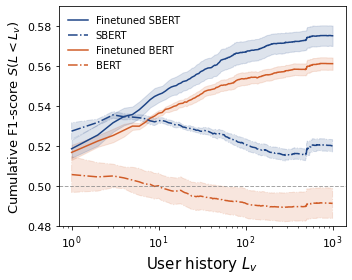

In [25]:
colors = ['#D05C27', '#1D4486', '#D05C27', '#1D4486']
lstyle = ['-','-','-.','-.']
fig, ax = plt.subplots(figsize=(5,4))

for idx, model_type in enumerate(model_types):
    plt.plot(np.arange(1,1001), model2mat_f1[model_type].mean(axis=0), label='%s'%(model_labels[idx]), color=colors[idx], lw=1.5, ls=lstyle[idx])
    yerr = model2mat_f1[model_type].std(axis=0)/np.sqrt(5)
    plt.fill_between(np.arange(1,1001), y1 = model2mat_f1[model_type].mean(axis=0)+yerr,y2 = model2mat_f1[model_type].mean(axis=0)-yerr, color=colors[idx], alpha=0.15, ls=lstyle[idx])
    #plt.errorbar(np.arange(1,1001), model2mat_f1[model_type].mean(axis=0),yerr=yerr, color=colors[idx], alpha=0.3, lw=2, ls=lstyle[idx], label='%s'%(model_labels[idx]))

ax.tick_params(axis='both', labelsize=11)

#baseline
plt.xlabel(r'User history $L_v$', fontsize=15)
plt.ylabel('Cumulative F1-score $S(L<L_v)$', fontsize=13)
plt.xscale('log')

custom_order = [1, 3, 0, 2]  
handles, labels = plt.gca().get_legend_handles_labels()
reordered_handles = [handles[idx] for idx in custom_order]
reordered_labels = [labels[idx] for idx in custom_order]
plt.legend(reordered_handles, reordered_labels, frameon=False, fontsize=10, loc=2)

    
#baseline
plt.axhline(0.5, ls='--', lw=1, color='gray', alpha=0.7, label='Random selection')
plt.ylim(0.48,0.59)  
  
plt.tight_layout()

In [26]:
model2mat_acc = {}

for model_type in model_types: 
        
    L = 1000
    mat_acc  = np.zeros((5,L))
    
    for data_idx in range(0,5):
        print(model_type, data_idx)
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
        
        for i in range(L):
            df_ = df_sample[df_sample['votelen']<=i+1]
            mat_acc[data_idx, i] = get_accuracy(df_['true_outcome'], df_['predicted_outcome'])
    
    
    model2mat_acc[model_type] = mat_acc

model_bert_ft 0
model_bert_ft 1
model_bert_ft 2
model_bert_ft 3
model_bert_ft 4
model_roberta-base_ft 0
model_roberta-base_ft 1
model_roberta-base_ft 2
model_roberta-base_ft 3
model_roberta-base_ft 4
model_bert 0
model_bert 1
model_bert 2
model_bert 3
model_bert 4
model_roberta-base 0
model_roberta-base 1
model_roberta-base 2
model_roberta-base 3
model_roberta-base 4


In [ ]:
"""for model_type in model_types:
    with open('../dataset/Downstream_result_vs_length/length2acc_mat_%s'%(model_type), 'wb') as f:
        pickle.dump(model2mat_acc[model_type], f)
        
        
model2mat_acc = {}
for model_type in model_types:
    with open('../dataset/Downstream_result_vs_length/length2acc_mat_%s'%(model_type), 'rb') as f:
        model2mat_acc[model_type] = pickle.load(f)        
"""

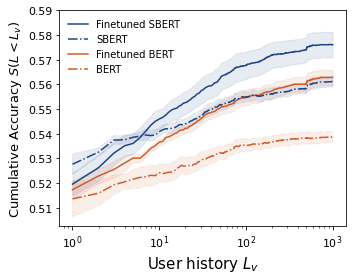

In [27]:
colors = ['#D05C27', '#1D4486', '#D05C27', '#1D4486']
lstyle = ['-','-','-.','-.']
fig, ax = plt.subplots(figsize=(5,4))

for idx, model_type in enumerate(model_types):
    plt.plot(np.arange(1,1001), model2mat_acc[model_type].mean(axis=0), label='%s'%(model_labels[idx]), color=colors[idx], lw=1.5, ls=lstyle[idx])
    yerr = model2mat_acc[model_type].std(axis=0)/np.sqrt(5)
    plt.fill_between(np.arange(1,1001), y1 = model2mat_acc[model_type].mean(axis=0)+yerr,y2 = model2mat_acc[model_type].mean(axis=0)-yerr, color=colors[idx], alpha=0.1, ls=lstyle[idx])

ax.tick_params(axis='both', labelsize=11)

#baseline
plt.xlabel(r'User history $L_v$', fontsize=15)
plt.ylabel('Cumulative Accuracy $S(L<L_v)$', fontsize=13)
plt.xscale('log')

custom_order = [1, 3, 0, 2]  
handles, labels = plt.gca().get_legend_handles_labels()
reordered_handles = [handles[idx] for idx in custom_order]
reordered_labels = [labels[idx] for idx in custom_order]
plt.legend(reordered_handles, reordered_labels, frameon=False, fontsize=10, loc=2)

    
#baseline
#plt.axhline(0.5, ls='--', lw=1.5, color='gray', alpha=0.7, label='Random selection')
plt.ylim(top=0.59)    
  
plt.tight_layout()

In [28]:
model2mat = {}

for model_type in model_types: 
        
    L = 11
    mat  = np.zeros((5,L))
    
    for data_idx in range(0,5):
        #print(model_type, data_idx)
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
        ex = 2
        for i in range(L):
            df_ = df_sample[(ex**i<=df_sample['votelen']) & (df_sample['votelen']<ex**(i+1))]
            mat[data_idx, i] = get_f1_score(df_['true_outcome'], df_['predicted_outcome'])
            print(ex**i,'-' ,ex**(i+1), len(df_))
            
    model2mat[model_type] = mat

    print(model_type)
    print(mat)

1 - 2 2877
2 - 4 3594
4 - 8 3930
8 - 16 4514
16 - 32 4439
32 - 64 4725
64 - 128 3933
128 - 256 3037
256 - 512 1756
512 - 1024 610
1024 - 2048 676
1 - 2 3168
2 - 4 3777
4 - 8 4198
8 - 16 4975
16 - 32 4742
32 - 64 5004
64 - 128 4235
128 - 256 2894
256 - 512 1797
512 - 1024 665
1024 - 2048 671
1 - 2 2774
2 - 4 3475
4 - 8 4070
8 - 16 4796
16 - 32 4952
32 - 64 5491
64 - 128 4699
128 - 256 3687
256 - 512 1596
512 - 1024 1398
1024 - 2048 497
1 - 2 3037
2 - 4 3440
4 - 8 3391
8 - 16 3802
16 - 32 3569
32 - 64 3515
64 - 128 3087
128 - 256 2170
256 - 512 1082
512 - 1024 588
1024 - 2048 685
1 - 2 2626
2 - 4 3195
4 - 8 3854
8 - 16 4366
16 - 32 4490
32 - 64 4912
64 - 128 4355
128 - 256 3204
256 - 512 1768
512 - 1024 902
1024 - 2048 385
model_bert_ft
[[0.52439845 0.54266051 0.53839179 0.56035371 0.58056818 0.57712745
  0.55857493 0.5783447  0.65651677 0.54095435 0.57062116]
 [0.50327993 0.52924649 0.55192641 0.56608341 0.57514212 0.58449636
  0.59630291 0.59623863 0.60655805 0.66766917 0.56785777]
 [0

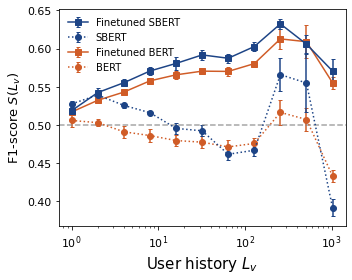

In [29]:
colors = ['#D05C27', '#1D4486', '#D05C27', '#1D4486']
lstyle = ['s-','s-','o:','o:']
fig, ax = plt.subplots(figsize=(5,4))

for idx, model_type in enumerate(model_types):
    x = [ex**l for l in range(L)]
    y = pd.DataFrame(model2mat[model_type]).mean()

    #plt.plot(x, y, color=colors[idx], lw=1.5, ls=lstyle[idx],  label='%s'%(model_labels[idx]))
    yerr = model2mat[model_type].std(axis=0)/np.sqrt(5)
    #plt.fill_between(x, y1 = y+yerr, y2=y-yerr, color=colors[idx], alpha=0.1, ls=lstyle[idx])
    plt.errorbar(x, y, yerr = yerr, color=colors[idx], fmt=lstyle[idx], capsize=2, label='%s'%(model_labels[idx]))

ax.tick_params(axis='both', labelsize=11)

#baseline
plt.xlabel(r'User history $L_v$', fontsize=15)
plt.ylabel('F1-score $S(L_v)$', fontsize=13)
plt.xscale('log')

custom_order = [1, 3, 0, 2]  
handles, labels = plt.gca().get_legend_handles_labels()
reordered_handles = [handles[idx] for idx in custom_order]
reordered_labels = [labels[idx] for idx in custom_order]
plt.legend(reordered_handles, reordered_labels, frameon=False, fontsize=10, loc=2)

    
#baseline
#plt.ylim(top=0.59)    
plt.axhline(0.5, ls='--', lw=1.5, color='gray', alpha=0.7, label='Random selection')
  
plt.tight_layout()

## Length distribution

In [30]:
def logbinning(data, numbin=30):
    # log-scaled bins
    bins = np.logspace(0, np.log2(max(data)), num=numbin, base=2)
    widths = (bins[1:] - bins[:-1])

    # Calculate histogram
    hist = np.histogram(data, bins=bins)
    # normalize by bin width
    hist_norm = hist[0]/widths

    # plot it!
    x = bins[:-1]
    y = hist_norm
    
    return x, y, widths

In [31]:
Ls = []
for data_idx in range(5):
    
    result = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_types[0])) 
    
    df_g = result.groupby('username')
      
    votelengths = []
    for g, df_ in df_g:
        votelengths.append(df_['votelen'].iloc[0])
        
    Ls.append(votelengths)

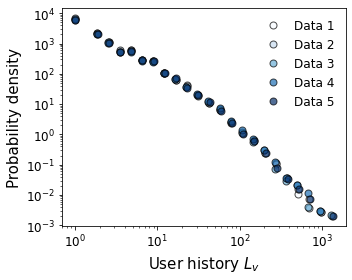

In [32]:
#colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

viridis_map = plt.cm.get_cmap('Blues')
color_values = np.linspace(0, 1, 5)
cmap = [viridis_map(color_val) for color_val in color_values]

plt.figure(figsize=(5,4))

for i in range(len(Ls)):
    x, y, widths = logbinning(Ls[i], numbin=25)
    plt.loglog(x, y, 'o', ms=7, alpha=0.7, markeredgecolor='k', c=cmap[i],  label='Data %d'%(i+1))

plt.xlabel(r'User history $L_v$', fontsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
#plt.savefig('../fig/vote_length_distribution(5fold_data).pdf', transparent=True)
plt.show()

## Visualization - belief space

In [33]:
model_types = ['model_bert_ft', 'model_roberta-base_ft', 'model_bert', 'model_roberta-base']
model_labels = ['BERT (Fine-tuned)', 'S-BERT (Fine-tuned)', 'BERT', 'S-BERT'] 
data_idx = 0

In [35]:
#load dictionary {beliefs: embedding vector}  

model2beleifemb = {}
for model_type in model_types:
    with open('../dataset/BeliefEmbeddingResults/BeliefEmbeddings_data(0)_model(%s).p'%(model_type), 'rb') as f:
        model2beleifemb[model_type] = pickle.load(f)


### load belief vectors

In [36]:
belief_keys = list(model2beleifemb['model_roberta-base_ft'].keys())
belief_vectors = list(model2beleifemb['model_roberta-base_ft'].values())

idx2belief = {}
belief2idx = {}

for i in range(len(belief_keys)):
    idx2belief[i] = belief_keys[i]
    belief2idx[belief_keys[i]] = i

## PCA of belief vectors

In [37]:
from sklearn.manifold import TSNE                   # final reduction
from sklearn.decomposition import PCA                   # final reduction

pca = PCA(random_state=42)
pca.fit(belief_vectors)
pca_vectors = pca.transform(belief_vectors)
pca_x_vals = np.array([v[0] for v in pca_vectors])
pca_y_vals = np.array([v[1] for v in pca_vectors])

dat_pc = pd.DataFrame({'x':pca_x_vals, 'y':pca_y_vals})

### Entire belief space

<Figure size 720x576 with 0 Axes>

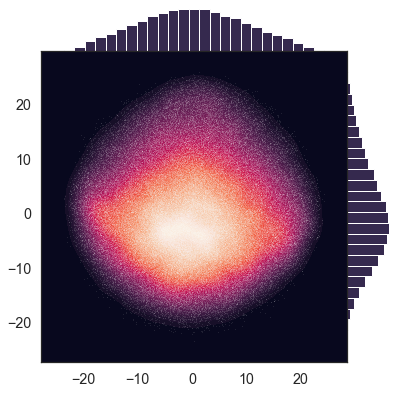

In [38]:
rc = {'figure.figsize':(10,8)}
sns.set_theme(style="white", font_scale=1.3, rc=rc)


plt.figure()
g = sns.JointGrid(data=dat_pc, x="x", y="y", space=0.0, ratio=7)

g.ax_joint.set_facecolor("black")

g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0,
             cmap="rocket",
             levels=100)

sns.scatterplot(x=pca_x_vals, y=pca_y_vals, fc="w", s=0.1,  ax=g.ax_joint)

g.plot_marginals(sns.histplot, color="#35294E", alpha=1, bins=25)

g.set_axis_labels(xlabel=None, )

#plt.savefig('../fig/BeliefSpaceExamples/belief_space_visualization_smooth.png', transparent=True, bbox_inches='tight')
plt.show()

### Beliefs including specific keywords

In [39]:
def get_related_beliefs(keywords, pc_x=0, pc_y=1): 
    #pc_x, pc_y = pc index
    related_beliefs = set()
    related_beliefs_vectors = []
    related_beliefs_pcvec = []

    for e in belief_keys:
        for k in keywords:
            if k.lower() in e.lower(): #convert to lower case 
                related_beliefs.add(e)
    
    related_beliefs = list(related_beliefs)
    for b in related_beliefs:
        b_idx = belief2idx[b]
        related_beliefs_vectors.append(belief_vectors[b_idx])
        related_beliefs_pcvec.append(pca_vectors[b_idx])

    related_beliefs_vectors = np.array(related_beliefs_vectors)            
    related_beliefs_pcvec   = np.array(related_beliefs_pcvec)

    x = related_beliefs_pcvec[:,pc_x]
    y = related_beliefs_pcvec[:,pc_y]
    
    dat = pd.DataFrame({'x':x, 'y':y, 'belief':related_beliefs})
    
    print("N samples:", len(x))
    return x, y, dat

In [40]:
def draw_keyword_kde(keywords, pc_x=0, pc_y=1, palette='rocket', labeloff=0):
    
    color = palette
            
    x, y, dat = get_related_beliefs(keywords, pc_x, pc_y)
    sns.set_theme(style="white", font_scale=1.3)
    g = sns.JointGrid(data=dat, x="x", y="y", space=0.0, ratio=7)
    
    
    sns.kdeplot(data=dat, x='x', y='y', fill=True, thresh=0, cmap=color, levels=100, ax=g.ax_joint)
    g.ax_joint.set_facecolor("black")
    g.plot_marginals(sns.histplot, color="#35294E", alpha=1, bins=25)
    g.set_axis_labels(xlabel=None)
    
    ax=g.ax_joint
    ax.set_xticks([-20, 0, 20])
    
    if labeloff==0:
        if len(keywords) > 2:
            ax.text(.02, .97,  s=", ".join(keywords), ha='left', va='top', color='w', fontsize=22, transform=ax.transAxes)
        else:
            ax.text(.02, .97,  s=", ".join(keywords), ha='left', va='top', color='w', fontsize=23, transform=ax.transAxes)
        
    return g

N samples: 5324


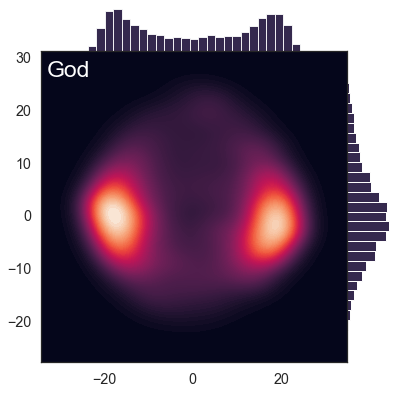

In [41]:
keywords = ['God']
draw_keyword_kde(keywords, labeloff=0)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=0, bbox_inches='tight')

## PC1-PC2

N samples: 908
N samples: 3860
N samples: 1302
N samples: 1392
N samples: 464
N samples: 380
N samples: 242
N samples: 710


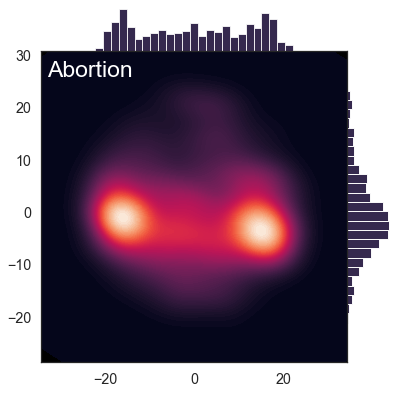

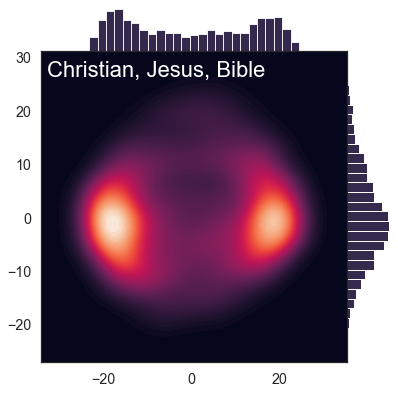

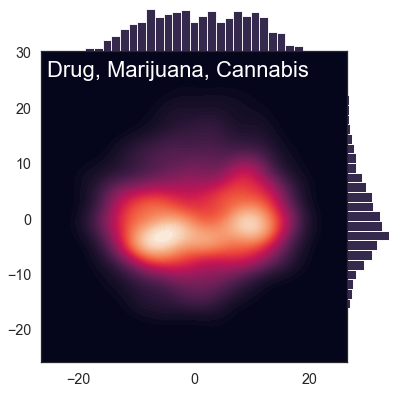

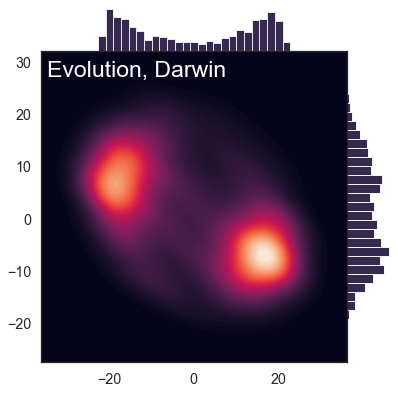

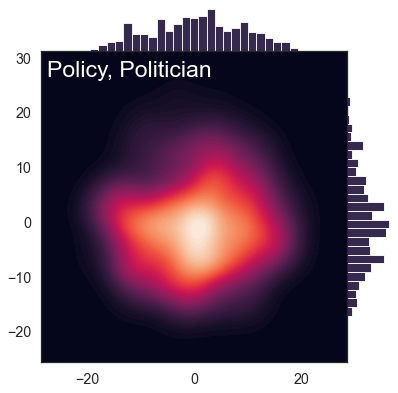

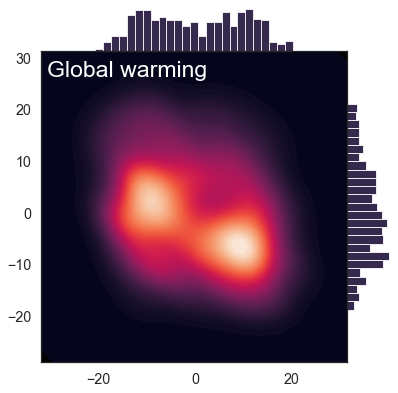

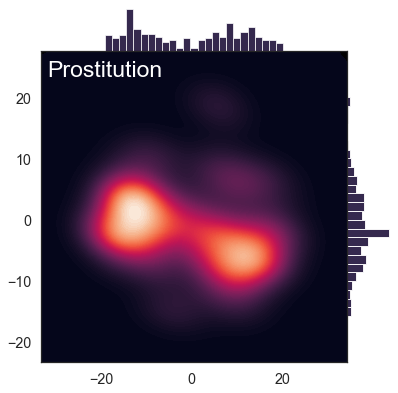

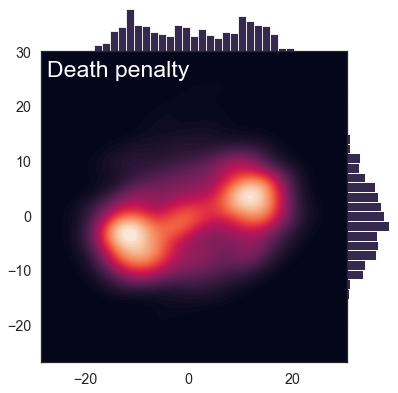

In [42]:
#Data
keywords = ['Abortion']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Christian', 'Jesus', 'Bible']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Drug', 'Marijuana', 'Cannabis']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Evolution','Darwin']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Policy', 'Politician']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Global warming']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Prostitution']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Death penalty']
draw_keyword_kde(keywords)
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

### PC2 - PC3

N samples: 342
N samples: 138


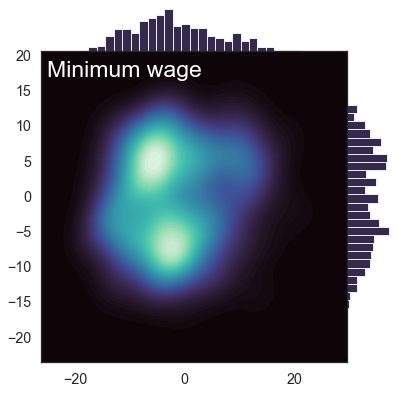

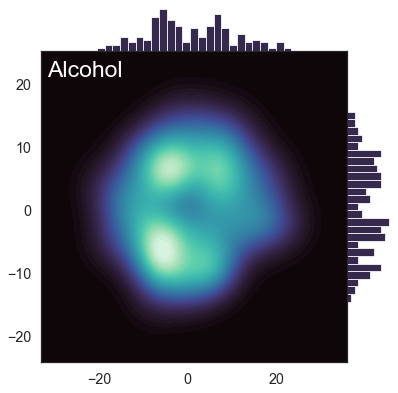

In [44]:
keywords = ['Minimum wage']
draw_keyword_kde(keywords, 1, 2, palette='mako')
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Alcohol']
draw_keyword_kde(keywords, 1, 2, palette='mako')
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

### Higher dimension

N samples: 324
N samples: 158
N samples: 140


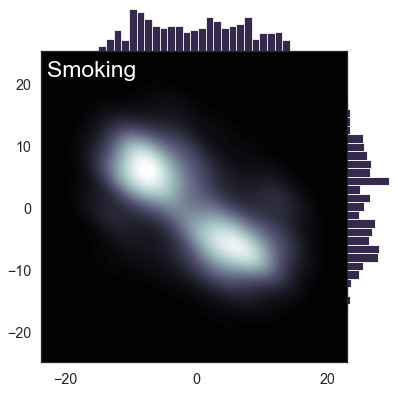

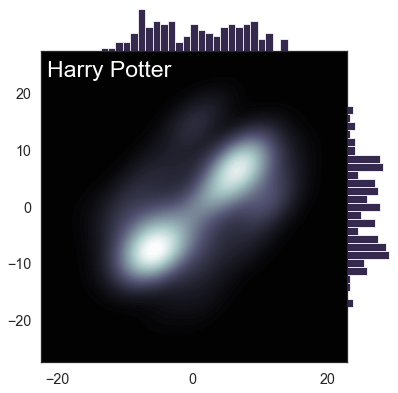

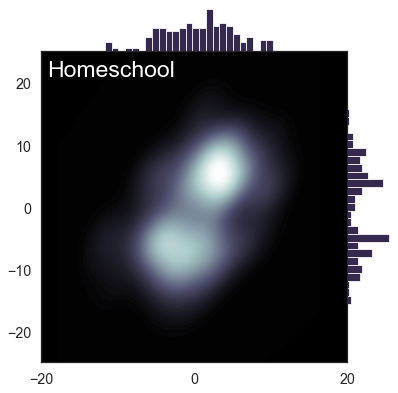

In [46]:
keywords = ['Smoking']
draw_keyword_kde(keywords, 3, 4, palette='bone')
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Harry Potter']
draw_keyword_kde(keywords, 2, 3, palette='bone')
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

keywords = ['Homeschool']
draw_keyword_kde(keywords, 2, 3, palette='bone')
#plt.savefig('../fig/BeliefSpaceExamples/belief_kdeplot_keyword_(%s)'%(keywords[0]), transparent=False, bbox_inches='tight')

## + UMAP of belief vectors

In [56]:
import umap

In [57]:
reducer = umap.UMAP(n_neighbors=20, n_components=2, random_state=42, spread=3 )
data_2d = reducer.fit_transform(belief_vectors)

/Users/byunghwee/miniforge3/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [58]:
dat_umap = pd.DataFrame({'x':data_2d[:,0], 'y':data_2d[:,1]})
dat_umap.head()

,x,y
0,1.916479,-0.008987
1,-0.305726,6.860794
2,6.805717,-1.217850
3,9.789492,6.680282
4,1.443168,-4.058787


<AxesSubplot:xlabel='x', ylabel='y'>

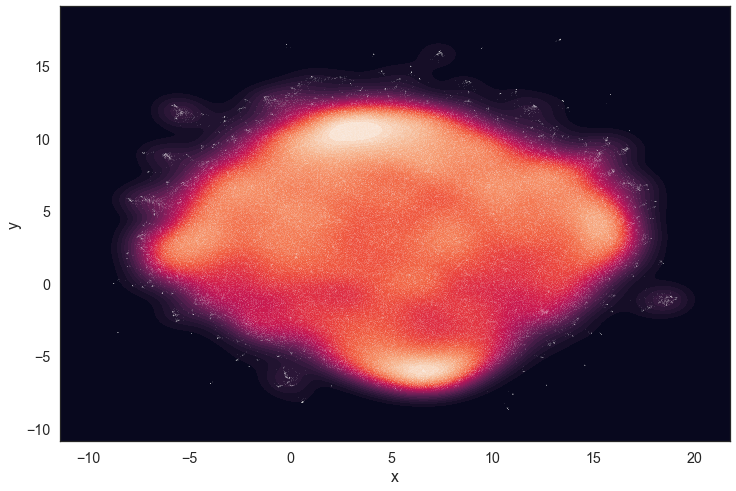

In [59]:
fig,ax = plt.subplots(figsize=(12,8))
sns.kdeplot(x=dat_umap['x'], y=dat_umap['y'], cmap='rocket', fill=True, thresh=0, levels=100, ax=ax)
sns.scatterplot(x=dat_umap['x'], y=dat_umap['y'], fc="w", s=0.1,  ax=ax)


<Figure size 864x576 with 0 Axes>

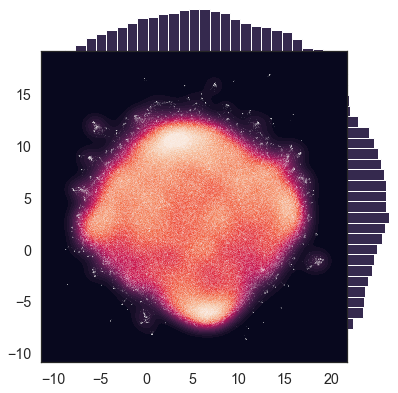

In [60]:
rc = {'figure.figsize':(12,8)}
sns.set_theme(style="white", font_scale=1.3, rc=rc)


plt.figure()
g = sns.JointGrid(data=dat_umap, x="x", y="y", space=0.0, ratio=7)

g.ax_joint.set_facecolor("black")

g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0,
             cmap="rocket",
             levels=100)

sns.scatterplot(x=dat_umap['x'], y=dat_umap['y'], fc="w", s=0.1,  ax=g.ax_joint)

g.plot_marginals(sns.histplot, color="#35294E", alpha=1, bins=25)

g.set_axis_labels(xlabel=None, )

#plt.savefig('../fig/BeliefSpaceExamples(UMAP)/belief_space_visualization_smooth.png', transparent=True, bbox_inches='tight')
plt.show()

In [61]:
def get_related_beliefs_umap(keywords): 
    related_beliefs = set()
    related_beliefs_umapvec = []

    for e in belief_keys:
        for k in keywords:
            if k.lower() in e.lower(): #convert to lower case 
                related_beliefs.add(e)
    
    related_beliefs = list(related_beliefs)
    
    for b in related_beliefs:
        b_idx = belief2idx[b]
        related_beliefs_umapvec.append(data_2d[b_idx])

    related_beliefs_umapvec = np.array(related_beliefs_umapvec)

    x = related_beliefs_umapvec[:,0]
    y = related_beliefs_umapvec[:,1]
    
    dat = pd.DataFrame({'x':x, 'y':y, 'belief':related_beliefs})
    
    print("N samples:", len(x))
    return x, y, dat

In [62]:
def draw_keyword_kde_umap(keywords, palette='rocket', labeloff=0):
    
    color = palette
            
    x, y, dat = get_related_beliefs_umap(keywords)    
    sns.set_theme(style="white", font_scale=1.3)
    g = sns.JointGrid(data=dat, x="x", y="y", space=0.0, ratio=7)
    
    ax = g.ax_joint
    #ax.fill_betweenx([30, 30], -30, 30, color='black')
    sns.kdeplot(data=dat, x='x', y='y', fill=True, thresh=0.0, cmap=color, levels=100, ax=ax)
    ax.set_facecolor("black")
    g.plot_marginals(sns.histplot, color="#DF6E50", alpha=1, linewidth=0.5, edgecolor='k', bins=25)
    g.set_axis_labels(xlabel=None)
        
    
    for line in plt.gca().get_lines():
        line.set_color('k')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    

    
    if labeloff==0:
        if len(keywords) > 2:
            ax.text(.02, .97,  s=", ".join(keywords), ha='left', va='top', color='w', fontsize=22, transform=ax.transAxes)
        else:
            ax.text(.02, .97,  s=", ".join(keywords), ha='left', va='top', color='w', fontsize=23, transform=ax.transAxes)
    
    return g

In [63]:
def draw_scatter_umap(keywords, ax, color='r', alpha=1):
    
    x, y, dat = get_related_beliefs_umap(keywords)
    sns.scatterplot(x=dat['x'], y=dat['y'], marker='o', color=color, s=5,  alpha=alpha, linewidth=0.0,
                    ax=ax, label='%s'%", ".join(keywords))
    #ax.set_axis_off()

N samples: 5324
N samples: 908
N samples: 1618
N samples: 242
N samples: 380
N samples: 1392
N samples: 710
N samples: 324
N samples: 342
N samples: 158


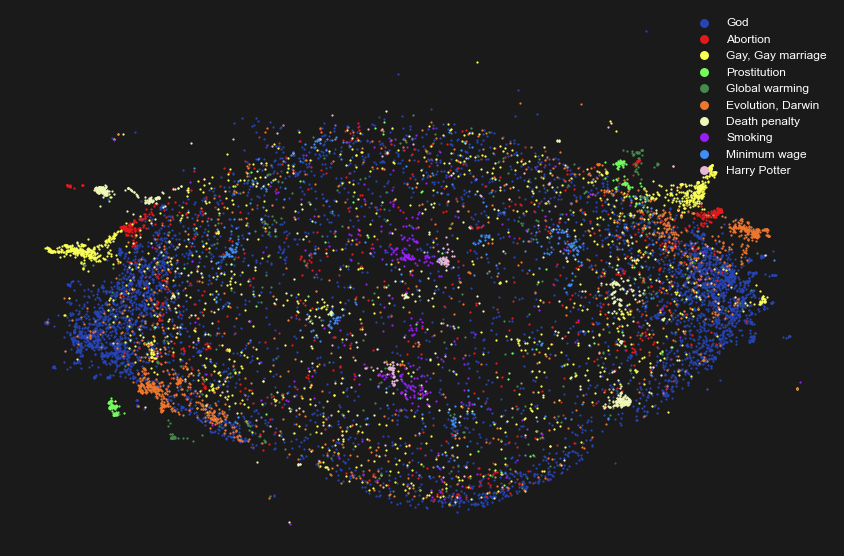

In [73]:
keywords_list = [['Abortion'], 
                 ['Gay','Gay marriage'], 
                 ['Prostitution'], 
                 ['Global warming'], 
                 ['Evolution','Darwin'], 
                 ['Death penalty'],
                 ['Smoking'], 
                 ['Minimum wage'],
                 ['Harry Potter']]

colors = [
"#e31a1c", 
"#FAFF54",
"#75FB5E",
"#45894C",
"#EE772F",
"#EFF8B9",
"#991EF6",
"#3F8DF7",
"#E8B8D8",
]

sns.set_theme(style="white", font_scale=1.3)

fig, ax = plt.subplots(facecolor='k', figsize=(12,8))
draw_scatter_umap(['God'], ax, color='#2744B4', alpha=1)#323690

for idx, keyword in enumerate(keywords_list):
    #print(keyword)
    color = plt.cm.gist_rainbow(idx / len(keywords_list))
    draw_scatter_umap(keyword, ax, color=colors[idx])
    
    
ax.set_facecolor('k')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

for pos in ['right', 'top', 'bottom', 'left']: 
    ax.spines[pos].set_visible(False)

ax.legend(markerscale=4, loc=1, fontsize=12, frameon=False, labelcolor='w')
plt.tight_layout()
#plt.savefig('../fig/BeliefSpaceExamples(UMAP)/keywords_umap.png', dpi=300)
plt.show()


N samples: 5324
N samples: 908
N samples: 1618
N samples: 242
N samples: 380
N samples: 1392
N samples: 710
N samples: 342
N samples: 138
N samples: 158
N samples: 140
N samples: 324


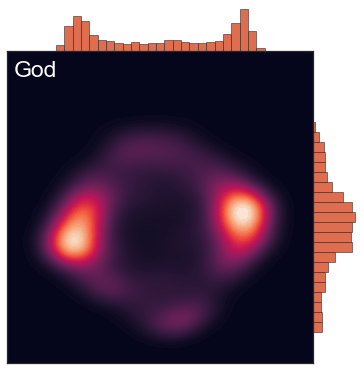

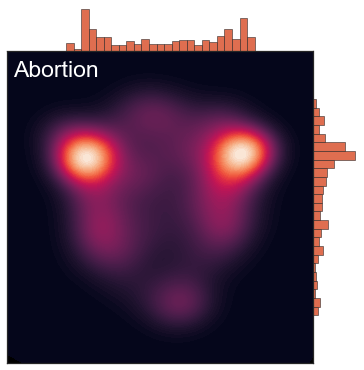

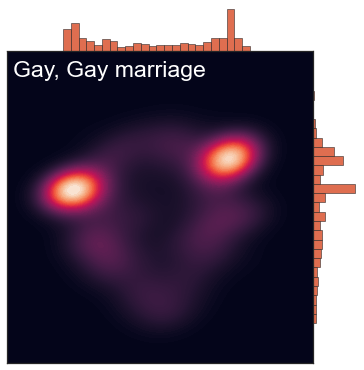

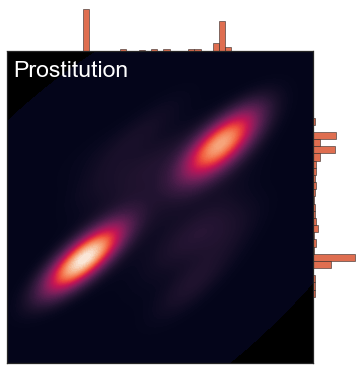

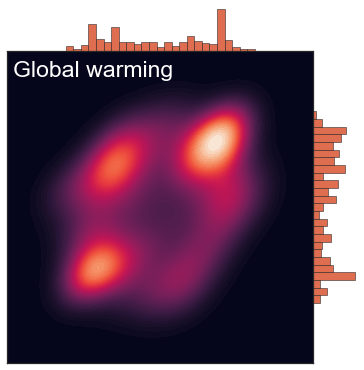

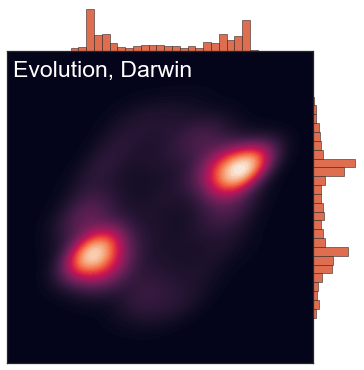

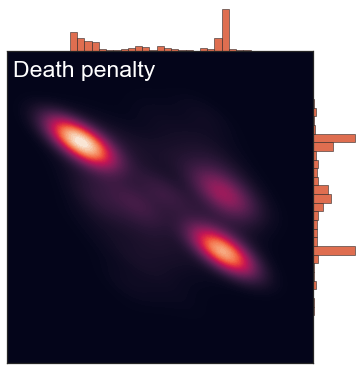

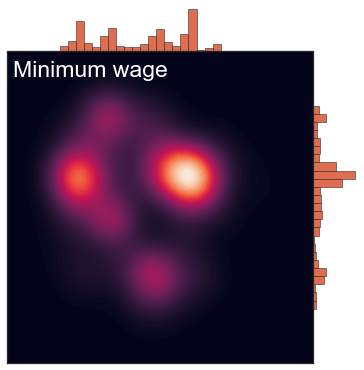

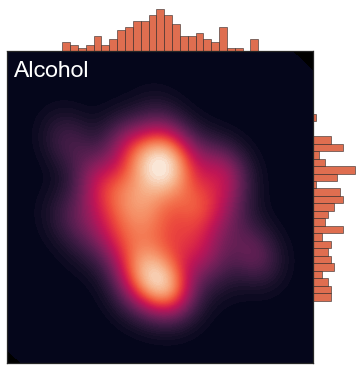

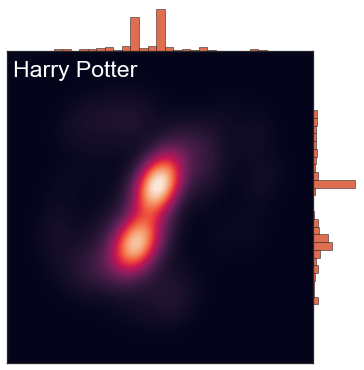

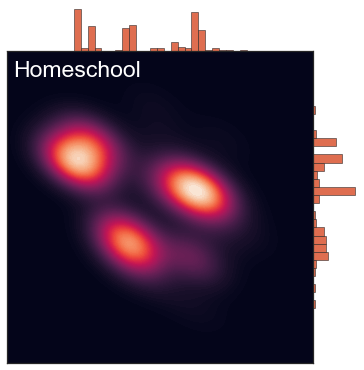

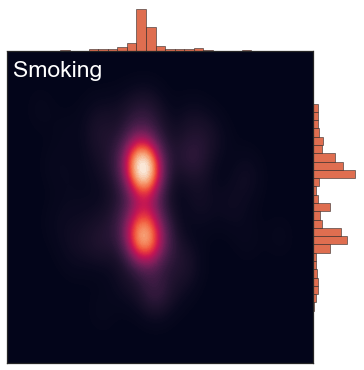

In [65]:
keywords_list = [['God'], ['Abortion'], ['Gay','Gay marriage'], ['Prostitution'], 
                 ['Global warming'], ['Evolution','Darwin'], ['Death penalty'], 
                 ['Minimum wage'], ['Alcohol'], ['Harry Potter'], ['Homeschool'], ['Smoking']]

for idx, keyword in enumerate(keywords_list):

    draw_keyword_kde_umap(keyword)
    
    #plt.savefig('../fig/BeliefSpaceExamples(UMAP)/belief_kdeplot_keyword_(%s).png'%(keyword[0]), 
    #        dpi=300, transparent=0, bbox_inches='tight')
    

## User embeddings

In [75]:
model_types = ['model_bert_ft', 'model_roberta-base_ft', 'model_bert', 'model_roberta-base']#, 'model_sbert_ft', 'model_sbert'
model_labels = ['BERT (Fine-tuned)', 'S-BERT (Fine-tuned)', 'BERT', 'S-BERT'] #, 'Finetuned SBERT roberta', 'SBERT roberta'

data_idx = 0

In [77]:
with open('../dataset/UserEmbeddings/user2embeddingvector_data(%d)_model(model_roberta-base_ft).p'%data_idx, 'rb') as f:
    user2embedding_ft = pickle.load(f)
    
with open('../dataset/UserEmbeddings/user2embeddingvector_data(%d)_model(model_roberta-base).p'%data_idx, 'rb') as f:
    user2embedding_base = pickle.load(f)    

In [78]:
len(user2embedding_ft), len(user2embedding_base)

(35447, 35447)

In [79]:
import json
with open('../dataset/userdata/users.json','r') as f:
    userinfo = json.load(f)

### Finding PC space of original belief space